# Introduction to Pyro
Let us import all the required modules.

In [1]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [2]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]


df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])


We convert a numpy array into a tensor for analysis with `Pyro`.

In [4]:
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

## Models in Pyro
Probabilistic models in Pyro are specified as Python functions model(*args, **kwargs) that generate observed data from latent variables using special primitive functions whose behavior can be changed by Pyro’s internals depending on the high-level computation being performed.

Specifically, the different mathematical pieces of model() are encoded via the mapping:
- latent random variables z <-> `pyro.sample()`.
- observed random variables x <-> `pyro.sample()` with the `obs` keyword argument.
- learnable parameters $\theta$ <-> `pyro.param`.
- plates <-> `pyro.plates` context manager.

#### Maximum Likelihood Linear Regression

mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

To build this up into a full probabilistic model for our dataset, we need to make the regression coefficients learnable parameters and add observation noise around the predicted mean. We can express this using the Pyro primitives introduced above and visualize the resulting model using pyro.render_model():

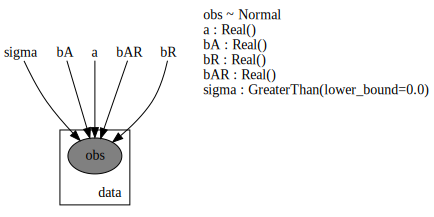

In [8]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(())) # randn returns a tensor filled with random samples from a N(0, 1)
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    # We
    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_params = True, render_distributions=True)

In our model the line `pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)` can represent either a latent variable or an observed variable depending on whether simple model is given a `log_gdp` value.
- When it is not given it simply samples from the distribution provided inside. 
- When it is given the statement will return log_gdp.

The `pyro.plate` primitive is used to show multiple conditionally independent and identically distributed random variables.\
They are equivalent to for loop statements in the way shown below.

`with pyro.plate("data", len(ruggedness)):
    return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)`

is equivalent to

```
result = torch.empty_like(ruggedness) #initialize an empty array of length as the number of observations.
for i in range(len(ruggedness)):
    result[i] = pyro.sample(f"obs_{i}", dist.Normal(mean, sigma), obs=log_gdp[i] if log_gdp is not None else None)
return result
```

It is mainly useful for vectorization purposes as it speeds up the computation.


#### Bayesian Linear Regression
To move into a bayesian linear regression problem we simply have to replace the param statements with sampling statements equipped with pyro distributions.

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

pyro.render_model(model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)